
Muhammad Hamas Khan

RCNN Segmentation





In [1]:
from functools import partial
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch, torchvision
import numpy as np
import cv2
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2 import model_zoo

import pycocotools.mask as coco_mask
from detectron2.config import get_cfg
import os
import json

In [2]:
OBJ_CLASSES = {
    0: 'leg',
    1: 'tableplate',
    2: 'hand',
    3: 'screwdriver',
    4: 'drill',
    5: 'background',
}

INV_OBJ_CATEGORIES = {v: k for k,v in OBJ_CLASSES.items()}
print(INV_OBJ_CATEGORIES)

{'leg': 0, 'tableplate': 1, 'hand': 2, 'screwdriver': 3, 'drill': 4, 'background': 5}


### 2.1 Fine-Tuning Part

In [3]:
# function to load the data
def get_dataset(ann_dir): # shouldn't have any parameters, but if we can use "partial" provided by functools
    # according to this: https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html
    N = 5 # for the length of an image name
    data = [] # list of dicts

    with open(f"{ann_dir}/annotations.json") as f:
        annotation_file = json.load(f)
    image_files = [img_file.get("file_name") for img_file in annotation_file.get("images")]
    annotations = [{
        "bbox": annotation.get("bbox"),
        "bbox_mode": BoxMode.XYWH_ABS,
        "category_id": annotation.get("category_id"),
        "segmentation": annotation.get("segmentation"),
        "image_id": annotation.get("image_id")
    } for annotation in annotation_file.get("annotations")]

    prefix = f"{ann_dir}"

    for img in image_files:
        color_file = f"{prefix}/{img}"
        d = {
            "file_name": color_file,
            "annotations": []
        }
        for annotation in annotations:
            # image id as a string
            iid = str(annotation.get("image_id"))
            length = len(iid)
            img_id = (N - length) * "0" + iid
            img_name = img.split("/")[1].split(".")[0] # example: "images/00001.jpg" -> "00000"
            if img_id == img_name:
                d["annotations"].append({**annotation})
        data.append(d)
    # essentially we need to write something like the "dexycb_hand_seg_func_mivos" function in the lecture notebook
    # and then load it to the detectron2 pipeline (see link)
    return data

In [4]:
cwd = os.getcwd()
data = get_dataset(os.path.join(cwd, "test-annotations"))
#with open("dataset.json", "w") as f:
#    f.write(json.dumps(data))

In [5]:
DatasetCatalog.register("our_dataset", partial(get_dataset,
                                               ann_dir=os.path.join(cwd, "test-annotations")))
MetadataCatalog.get("our_dataset").set(thing_classes=list(OBJ_CLASSES.values()))

namespace(name='our_dataset',
          thing_classes=['leg',
                         'tableplate',
                         'hand',
                         'screwdriver',
                         'drill',
                         'background'])

In [6]:
cfg = get_cfg()
#cfg.merge_from_file(os.path.join(cwd, "test-annotations", "cfg_mivos.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file("/home/student/Documents/PPHAU 2023/NS2_local/assets/mask_rcnn/cfg_mivos.yaml")
cfg.DATASETS.TRAIN = ("our_dataset", )

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE= 'cpu' #'cuda:0'
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(os.path.join(cwd, "test-annotations", "cfg_mivos.yaml"))  # Let training initialize from model zoo
#cfg.MODEL.WEIGHT = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 30
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(OBJ_CLASSES)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [7]:
# to fix distutils error
#%pip install setuptools==59.5.0

In [10]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[05/29 14:15:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
trainer.train()

[05/29 14:15:32 d2.engine.train_loop]: Starting training from iteration 0


/home/student/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/29 14:24:43 d2.utils.events]:  eta: 0:04:35  iter: 19  total_loss: 2.547  loss_cls: 0.7388  loss_box_reg: 0.8549  loss_mask: 0.6702  loss_rpn_cls: 0.05848  loss_rpn_loc: 0.1462    time: 27.4735  last_time: 29.0087  data_time: 0.0665  last_data_time: 0.0633   lr: 0.0015842  
[05/29 14:29:18 d2.utils.events]:  eta: 0:00:00  iter: 29  total_loss: 2.203  loss_cls: 0.6695  loss_box_reg: 0.8312  loss_mask: 0.5199  loss_rpn_cls: 0.04131  loss_rpn_loc: 0.1329    time: 27.4611  last_time: 27.9910  data_time: 0.0633  last_data_time: 0.0657   lr: 0.0024168  
[05/29 14:29:18 d2.engine.hooks]: Overall training speed: 28 iterations in 0:12:48 (27.4611 s / it)
[05/29 14:29:18 d2.engine.hooks]: Total training time: 0:12:49 (0:00:00 on hooks)


### 2.2 Comparison

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cwd, "output", "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/29 16:17:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/student/Documents/PPHAU 2023/NS2_local/output/model_final.pth ...


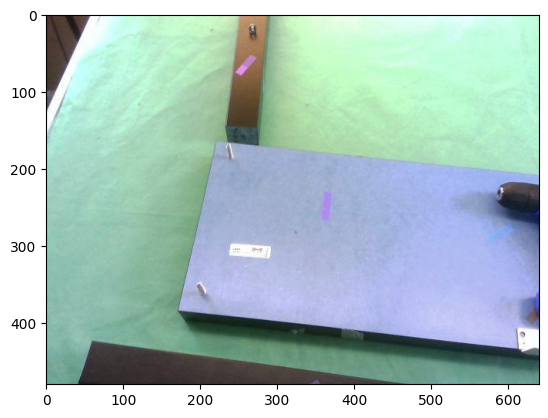

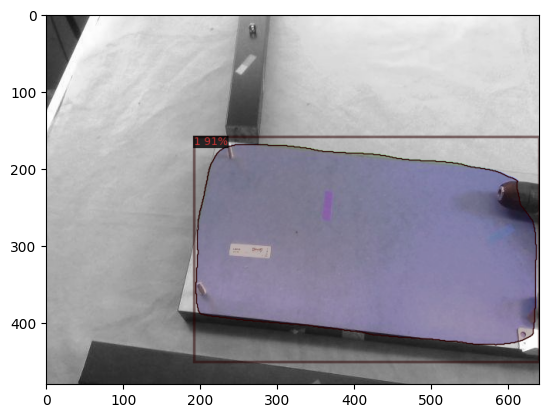

In [52]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# use this image as example in the following cells
EXAMPLE_IMG_ID = 1
EXAMPLE_IMG_NAME = "00001.jpg"


im = cv2.imread(os.path.join(cwd, "test-annotations", "images", EXAMPLE_IMG_NAME))
plt.imshow(im)
plt.show()

outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get("our_dataset2"), 
                scale=1.0,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

Basically, this is a great result for the very (very) short training time.

In [53]:
instances = outputs["instances"]

In [76]:
# some sanity check
instances

Instances(num_instances=1, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[191.5065, 158.9211, 640.0000, 451.2156]])), scores: tensor([0.9113]), pred_classes: tensor([1]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])

In [55]:
# preparing the semantic point cloud
semantic_mask = np.zeros_like(im[:, :, 0])
for i in range(len(instances)):
    mask = instances.pred_masks[i].detach().cpu().numpy().astype(bool)
    semantic_mask[mask] = instances.pred_classes[i]

In [56]:
# sanity check
unique, counts = np.unique(semantic_mask, return_counts=True)
dict(zip(unique, counts))

{0: 209125, 1: 98075}

In [57]:
def generate_pointcloud(semantic_mask):
    """
    class_colors = {
        "leg": [255, 0, 0],
        "tableplate": [0, 255, 0],
        "hand": [0, 0, 255],
        "screwdriver": [255, 255, 0],
        "drill": [255, 0, 255],
        "background": [0, 0, 0]
    }"""
    class_colors = {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 255, 0],
        4: [255, 0, 255],
        5: [0, 0, 0]
    }

    point_cloud = []

    for y in range(semantic_mask.shape[0]):
        for x in range(semantic_mask.shape[1]):
            class_label = semantic_mask[y, x]
            # to have our mapping
            if class_label == 0:
                class_label = 5

            if class_label in class_colors:
                color = class_colors[class_label]

                point_cloud.append([x, y, color[0], color[1], color[2]])

    point_cloud = np.array(point_cloud)
    return point_cloud

In [58]:
semantic_pointcloud = generate_pointcloud(semantic_mask)

In [59]:
# sanity check
unique, counts = np.unique(semantic_pointcloud[:, 2:], return_counts=True)
dict(zip(unique, counts))

{0: 823525, 255: 98075}

/tmp/ipykernel_40194/3400736117.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y[::-1], c=colors, cmap="RGB")


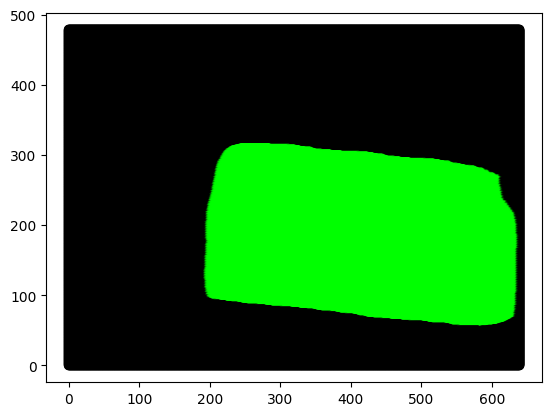

In [60]:
x = semantic_pointcloud[:, 0]
y = semantic_pointcloud[:, 1]
r = semantic_pointcloud[:, 2] / 255
g = semantic_pointcloud[:, 3] / 255
b = semantic_pointcloud[:, 4] / 255

colors = [(r_, g_, b_) for r_, g_, b_ in zip(r, g, b)]

plt.scatter(x, y[::-1], c=colors, cmap="RGB")
plt.show()

In [61]:
# preparing data for GT Mask
# Annotation information
with open(os.path.join(cwd, "test-annotations", "annotations.json")) as f:
    annotation_file = json.load(f)

annotations = [{
    "bbox": annotation.get("bbox"),
    "bbox_mode": BoxMode.XYWH_ABS,
    "category_id": annotation.get("category_id"),
    "segmentation": annotation.get("segmentation"),
    "image_id": annotation.get("image_id")
} for annotation in annotation_file.get("annotations")\
# only image 90 like above
    if annotation.get("image_id") == EXAMPLE_IMG_ID]

# dimensions of the mask (assuming it corresponds to the image size)
mask_height = 480
mask_width = 640

# Create an empty mask
gt_mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

# get polygon coordinates
polygon_coords_all = []
for annotation in annotations:
    polygon_coords = annotation["segmentation"][0]
    polygon_coords_all.append(np.array(polygon_coords, dtype=np.int32))


In [62]:
# sanity check
for polygon_coords in polygon_coords_all:
    print(polygon_coords.shape)
"""
cv2.fillPoly(gt_mask, [polygon_coords], color=255)

# Show the GT mask
cv2.imshow("GT Mask", gt_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

(66,)
(238,)
(46,)
(10,)


'\ncv2.fillPoly(gt_mask, [polygon_coords], color=255)\n\n# Show the GT mask\ncv2.imshow("GT Mask", gt_mask)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [63]:
# for GT Mask
def plot_mask(mask, polygon_coordinates):
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]
    
    for i, polygon_coords in enumerate(polygon_coordinates):
        polygon_coords = polygon_coords.reshape((-1, 2))
        cv2.fillPoly(mask_rgb, [polygon_coords], colors[i])

    plt.imshow(mask_rgb)
    plt.axis("off")
    plt.show()
    return mask_rgb

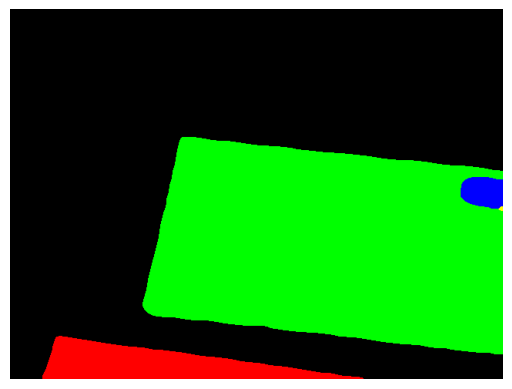

In [64]:
gt_mask_final = plot_mask(gt_mask, polygon_coords_all)

In [65]:
# sanity check
print(gt_mask_final.shape)
print(gt_mask_final)

(480, 640, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [67]:
# sanity check
np.array(colors).reshape((480, 640, 3)).shape

(480, 640, 3)

In [75]:
# pixel accuracy
mask_photo = np.array(colors).reshape((480, 640, 3))
print(mask_photo.shape, gt_mask_final.shape)

correct_pixels = np.sum(mask_photo == gt_mask_final)
total_pixels = mask_photo.shape[0]*mask_photo.shape[1]*3
pixels_acc = correct_pixels / total_pixels * 100
print("pixel wise acc:", pixels_acc)

(480, 640, 3) (480, 640, 3)
pixel wise acc: 86.99522569444444


86.995 % is very good in our case, because the training was very short and on CPU. But if one includes the background and compare the gt_mask with the inference mask, the similarity gets quite high.<br>
With longer training, there is a high scope of improvement.